In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.formula.api as smf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000000 # Jupyter notebook backend restricts number of points in plot
import plotly.plotly as py
from plotly.graph_objs import Figure,Layout,Scatter,Bar
from time import time
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,scale,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold,KFold,GridSearchCV,RandomizedSearchCV

### Creación de funciones

* La función plot_pie fué extraída de un notebook en Kaggle (espero encontrarla pronto para agregar la referencia=

* El resto de las funciones fueron creadas por mi para simplificarme algunas tareas repetitivas y/o que la función em entregue la interpretación del test directamente

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')
    
def transformacion_logaritmica(x):
    if(x==0):
        return 0
    else:
        return np.log(x)
    
def expected_values(var1,var2):
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    return expected

def chi2_test(var1,var2,alpha=0.95):
    #Creamos la tabla de contingencia con los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    #Creamos la tabla de valores esperados
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    #Creamos la tabla de contingencia sin los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2)
    #calculamos el valor calculado de chi2
    chi_squared_stat = (((contingencyTable-expected)**2)/expected).sum().sum()
    #calculamos los grados de libertad
    dof=(len(contingencyTable.columns)-1)*(len(contingencyTable.index)-1)
    #calculamos el valor crítico de chi2
    crit = sp.stats.chi2.ppf(q = alpha,df = dof)
    #calulamos el p-valor
    p_value = 1 - sp.stats.chi2.cdf(x=chi_squared_stat,df=dof)
    #testeamos la hipótesis nula de independencia entre las variables
    if(chi_squared_stat<=crit):
        print('se acepta H0, los valores son independientes y el p-valor es: {}'
              '\n el p-valor es:'.format(round(p_value,4)))
        print("los valores esperados son: "+ str(expected))
    else:
        print('Se rechaza H0, no hay evidencia para decir que los valores son independientes'
              '\n y el p-valor es: {}'.format(round(p_value,4)))
        print("los valores esperados son: "+ str(expected))

In [3]:
df=pd.read_csv("data_hr.csv",encoding='utf-8',sep=',')
print(df.shape)
df.head()

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Diccionario de variables

* Hay 14.999 registros y 10 variables, incluyendo el target. Cada registro corresponde a la información de un empleado.

* SL: Satisfacción del empleado con la compañia
* LE: last proyect evaluation
* NP: Número de proyectos en los que el empleado a trabajado durante el tiempo en la empresa
* AMH: Número de horas promedio trabajadas por el empleado en los últimos 12 meses 
* TSC: Tempo que ha estado en la compañia (en años)
* WA: Accidentes en el trabajo
* PL5Y: Promociones en los últimos 5 años
* Sales: Cada valor representa el nombre del departamento al cual pertenece el individuo
* Salary: Salario en rango (bajo, medio y alto)
* left: Es la variable target y nos indica con un 1 si la persona dejó la compañia y con un 0 cuando no

*Este dataset no toma en cuenta las personas que han sido despedidas, transferidas o contratatas durante el último año*

* A continuación mostramos los tipos de datos de cada una de las variables

In [4]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

## Preguntas de negocio propuestas

1.- Identifique cuáles son las variables que impactan en mayor medida que los mejores empleados dejen la compañia e interprete sus resultados como si tuviera que presentar el informe a un reclutador

2.- Proponer la forma de utilizar estos datos para efectuar acciones personalizadas y preventivas sobre los empleados sus descrubrimientos para disminuir la fuga de talentos en la empresa


## Preguntas técnicas propuestas

1.-Explique claramente cuál fue la metodología utilizada para determinar cuáles eran las variables que más impactan en la fuga de talentos

2.-Explique cómo seleccionó el modelo adecuado para resolver el problema y cómo controlo el sobreajuste en este proceso

## EDA

* Partimos el análisis haciendo un EDA (análisis exploratorio de datos) en donde comprenderemos la cantidad de valores NA's, distribución, relación con la variable target y correlaciones de cada una de las variables target

* Para esto utilizaremos las siguientes herramientas:
    * Histogramas
    * Boxplot (individuales y por categoría de la variable target)
    * Gráficos barra (individuales y por categoría de la variable target)
    * Gráficos de torta
    * Medidas de tendencia central (media, desviación estandar, mediana, percentiles)
    * Test Chi-2 para las variables categóricas no ordinales
    * Cálculo de la cantidad de NAs y el porcentaje de estos sobre el total de datos
    
    
    
**¿Por qué no hacer test ANOVA para las variables númericas?  porque el test Anova requiere el cumplimiento de 3 supuestos muy fuertes:**

    1.-Normalidad en la distribución de la variable numérica para cada valor de la categoría
    2.-Homogeneidad de la varianza en la variable numérica para cada categoría
    3.-Aleatoriedad de la muestra

**Para nuestras variables, es claro que estos supuestos no se cumplen y por lo tanto la aplicación del test conduciría a conclusiones equivocadas**
<https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-2.php>


In [5]:
value_list = []
missing_list = []
columns=df.columns
for col in columns:
    value_list.append((df[col].notnull()).sum())
    missing_list.append((df[col].isnull()).sum())

trace1 = Bar(
    x=columns,
    y=value_list ,
    name='Actual Values'
)
trace2 = Bar(
    x=columns,
    y=missing_list,
    name='Missing Values'
)

data = [trace1, trace2]
layout = Layout(
    barmode='stack',
    title='Count of missing values in continuous variables'
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

Información del dataset:
 las clases del target son: Counter({0: 11428, 1: 3571})


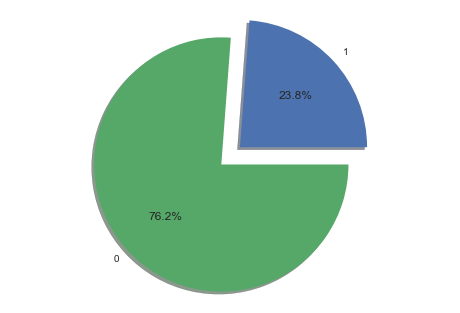

In [6]:
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(df.left)))
plot_pie(df.left)

### Satisfaction level

count    14999.000000
mean         0.612834
std          0.248631
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64


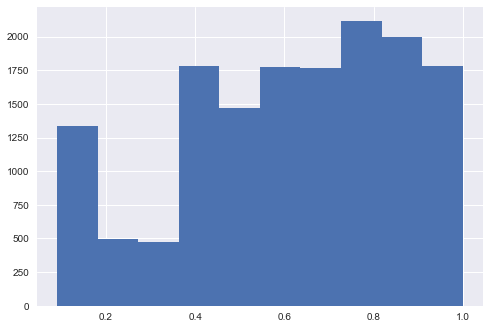

In [7]:
print(df['satisfaction_level'].describe())
df['satisfaction_level'].hist()

{'boxes': [<matplotlib.lines.Line2D at 0x12665ff28>],
 'caps': [<matplotlib.lines.Line2D at 0x1266709e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1266b8cc0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1266b8470>],
 'whiskers': [<matplotlib.lines.Line2D at 0x126668908>,
  <matplotlib.lines.Line2D at 0x126668b38>]}

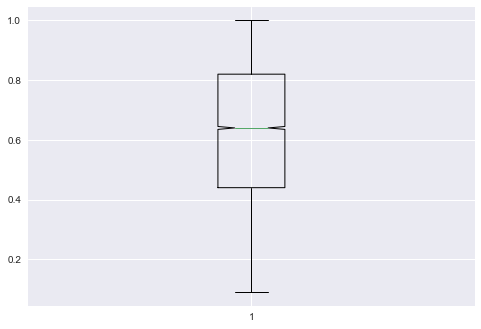

In [135]:
plt.boxplot(df.satisfaction_level,'rs')

        count      mean       std   min   25%   50%   75%   max
left                                                           
0     11428.0  0.666810  0.217104  0.12  0.54  0.69  0.84  1.00
1      3571.0  0.440098  0.263933  0.09  0.13  0.41  0.73  0.92


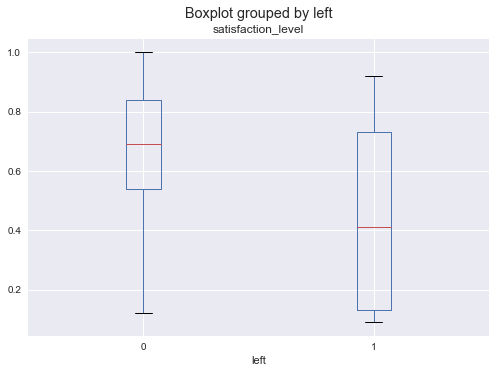

In [8]:
print(df.groupby('left')['satisfaction_level'].describe())
df.boxplot(column='satisfaction_level',by='left')

### Last evaluation

count    14999.000000
mean         0.716102
std          0.171169
min          0.360000
25%          0.560000
50%          0.720000
75%          0.870000
max          1.000000
Name: last_evaluation, dtype: float64


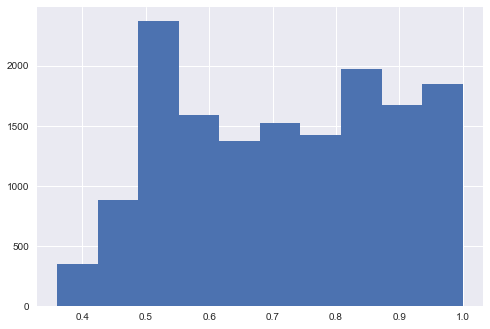

In [9]:
print(df.last_evaluation.describe())
df.last_evaluation.hist()

{'boxes': [<matplotlib.lines.Line2D at 0x126dfc8d0>],
 'caps': [<matplotlib.lines.Line2D at 0x126e05cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x126e16cc0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x126e0edd8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x126dfcac8>,
  <matplotlib.lines.Line2D at 0x126e05b00>]}

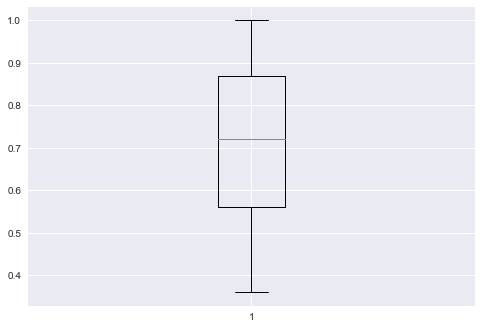

In [141]:
plt.boxplot(df.last_evaluation,0,'rs')

        count      mean       std   min   25%   50%   75%  max
left                                                          
0     11428.0  0.715473  0.162005  0.36  0.58  0.71  0.85  1.0
1      3571.0  0.718113  0.197673  0.45  0.52  0.79  0.90  1.0


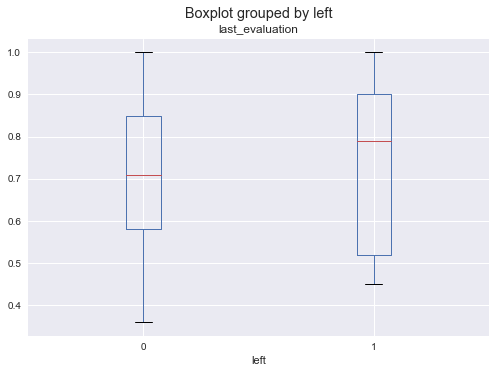

In [10]:
print(df.groupby('left')['last_evaluation'].describe())
df.boxplot(column='last_evaluation',by='left')

### Sales

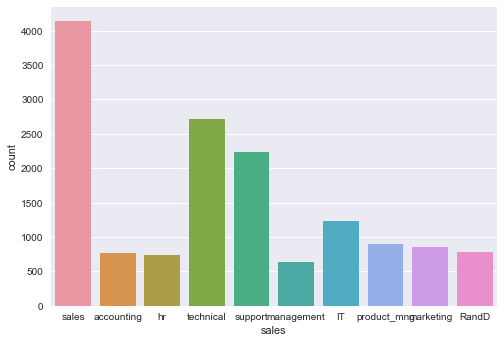

In [11]:
sns.countplot(x='sales', data=df)

sales        IT     RandD  accounting        hr  management  marketing  \
left                                                                     
0      0.777506  0.846252    0.734029  0.709066    0.855556   0.763403   
1      0.222494  0.153748    0.265971  0.290934    0.144444   0.236597   

sales  product_mng     sales   support  technical       All  
left                                                         
0         0.780488  0.755072  0.751009    0.74375  0.761917  
1         0.219512  0.244928  0.248991    0.25625  0.238083  


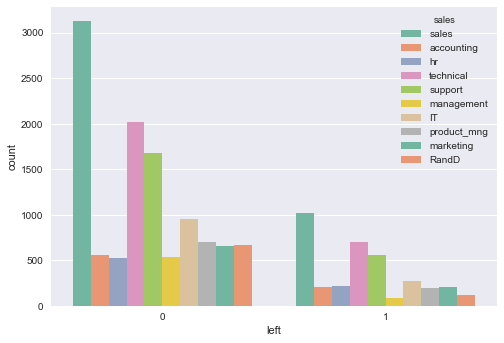

In [12]:
print(pd.crosstab(df.left,df.sales, margins=True,normalize='columns'))
sns.countplot(x='left', hue='sales', data=df, palette='Set2')

In [13]:
pd.crosstab(df.left,df.sales, margins=True,normalize='columns')

sales,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,All
left,,,,,,,,,,,
0,0.777506,0.846252,0.734029,0.709066,0.855556,0.763403,0.780488,0.755072,0.751009,0.74375,0.761917
1,0.222494,0.153748,0.265971,0.290934,0.144444,0.236597,0.219512,0.244928,0.248991,0.25625,0.238083


In [14]:
chi2_test(var1=df.left,var2=df.sales,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: sales          IT       RandD  accounting          hr  management   marketing  \
left                                                                            
0      934.872725  599.629042  584.390693  563.057004  480.008001  653.725182   
1      292.127275  187.370958  182.609307  175.942996  149.991999  204.274818   

sales  product_mng        sales      support    technical  
left                                                       
0        687.24955  3154.338289  1698.314021  2072.415494  
1        214.75045   985.661711   530.685979   647.584506  


### Salary

In [15]:
pd.crosstab(df.left,df.salary, margins=True,normalize='columns')

salary,high,low,medium,All
left,,,,
0,0.933711,0.703116,0.795687,0.761917
1,0.066289,0.296884,0.204313,0.238083


In [16]:
chi2_test(var1=df.left,var2=df.salary)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: salary        high          low       medium
left                                        
0       942.491899  5574.188146  4911.319955
1       294.508101  1741.811854  1534.680045


### Número de proyectos

count    14999.000000
mean         3.803054
std          1.232592
min          2.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: number_project, dtype: float64


{'boxes': [<matplotlib.lines.Line2D at 0x1274460f0>],
 'caps': [<matplotlib.lines.Line2D at 0x12744db70>,
 'fliers': [<matplotlib.lines.Line2D at 0x127455e48>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1274555f8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x127446a90>,
  <matplotlib.lines.Line2D at 0x127446cc0>]}

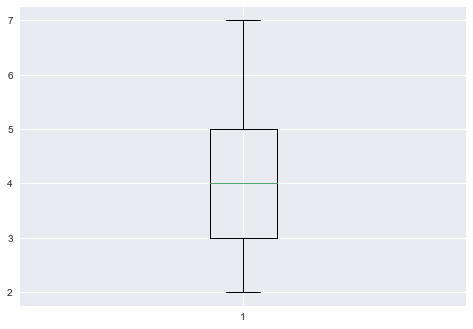

In [146]:
print(df.number_project.describe())
plt.boxplot(df.number_project,0,'rs')

number_project         2         3       4         5         6    7       All
left                                                                         
0               0.343802  0.982244  0.9063  0.778341  0.442078  0.0  0.761917
1               0.656198  0.017756  0.0937  0.221659  0.557922  1.0  0.238083


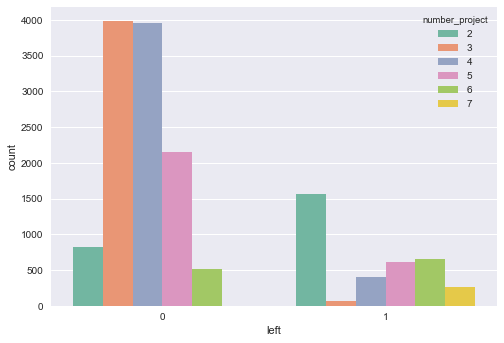

In [17]:
print(pd.crosstab(df.left,df.number_project, margins=True,normalize='columns'))
sns.countplot(x='left', hue='number_project', data=df, palette='Set2')

In [18]:
chi2_test(var1=df.left,var2=df.number_project,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: number_project            2            3            4           5           6  \
left                                                                            
0               1819.458897  3089.575305  3325.769718  2103.65411  894.491099   
1                568.541103   965.424695  1039.230282   657.34589  279.508901   

number_project          7  
left                       
0               195.05087  
1                60.94913  


### Número de horas promedio trabajadas en los últimos 12 meses

count    14999.000000
mean       201.050337
std         49.943099
min         96.000000
25%        156.000000
50%        200.000000
75%        245.000000
max        310.000000
Name: average_montly_hours, dtype: float64


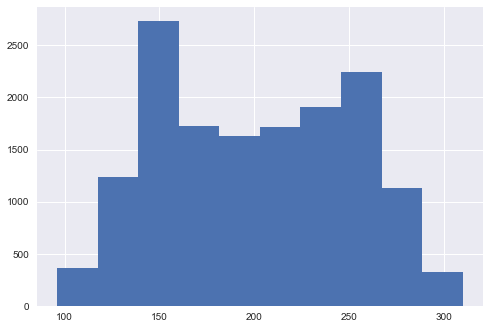

In [19]:
print(df.average_montly_hours.describe())
df.average_montly_hours.hist()

{'boxes': [<matplotlib.lines.Line2D at 0x126cb4668>],
 'caps': [<matplotlib.lines.Line2D at 0x126cffa90>,
 'fliers': [<matplotlib.lines.Line2D at 0x126d0ea58>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x126d06b70>],
 'whiskers': [<matplotlib.lines.Line2D at 0x126cb4f60>,
  <matplotlib.lines.Line2D at 0x126cff898>]}

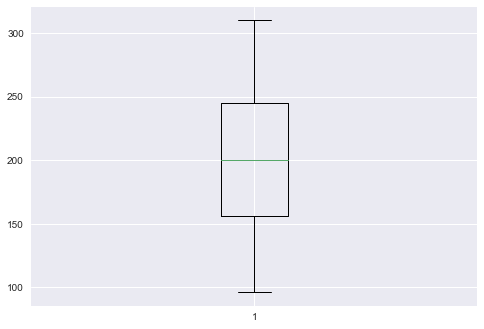

In [140]:
plt.boxplot(df.average_montly_hours,0,'rs')

        count        mean        std    min    25%    50%    75%    max
left                                                                   
0     11428.0  199.060203  45.682731   96.0  162.0  198.0  238.0  287.0
1      3571.0  207.419210  61.202825  126.0  146.0  224.0  262.0  310.0


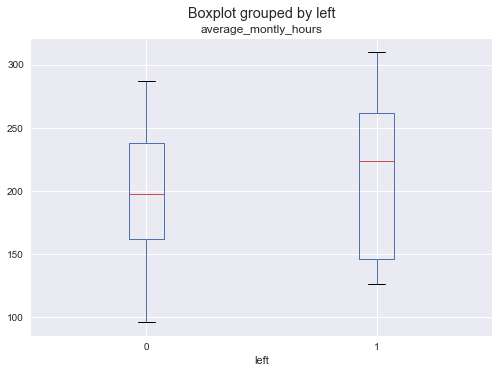

In [20]:
print(df.groupby('left')['average_montly_hours'].describe())
df.boxplot(column='average_montly_hours',by='left')

count    14999.000000
mean         3.498233
std          1.460136
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: time_spend_company, dtype: float64


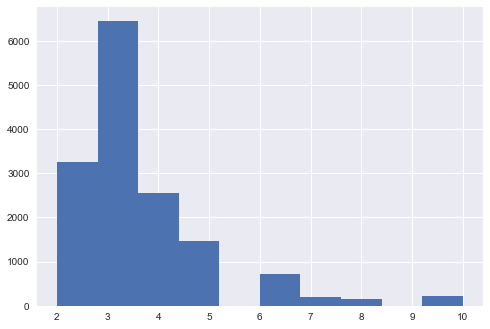

In [21]:
print(df.time_spend_company.describe())
df.time_spend_company.hist()

{'boxes': [<matplotlib.lines.Line2D at 0x1272f6860>],
 'caps': [<matplotlib.lines.Line2D at 0x127300c88>,
 'fliers': [<matplotlib.lines.Line2D at 0x12734fc50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x127345d68>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1272f6a58>,
  <matplotlib.lines.Line2D at 0x127300a90>]}

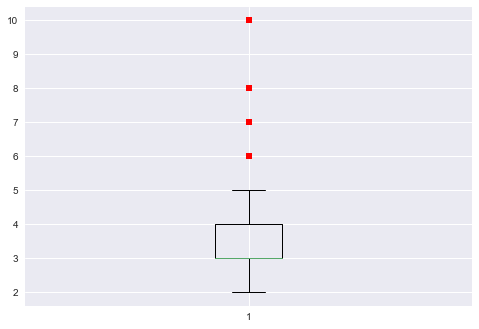

In [145]:
plt.boxplot(df.time_spend_company,0,'rs')

        count      mean       std  min  25%  50%  75%   max
left                                                       
0     11428.0  3.380032  1.562348  2.0  2.0  3.0  4.0  10.0
1      3571.0  3.876505  0.977698  2.0  3.0  4.0  5.0   6.0


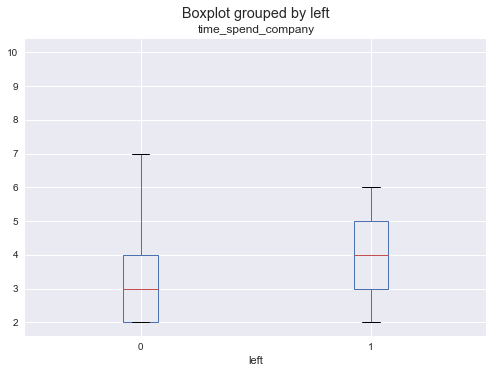

In [22]:
print(df.groupby('left')['time_spend_company'].describe())
df.boxplot(column='time_spend_company',by='left')

### Accidentes en el trabajo

Work_accident        0         1       All
left                                      
0              0.73484  0.922084  0.761917
1              0.26516  0.077916  0.238083


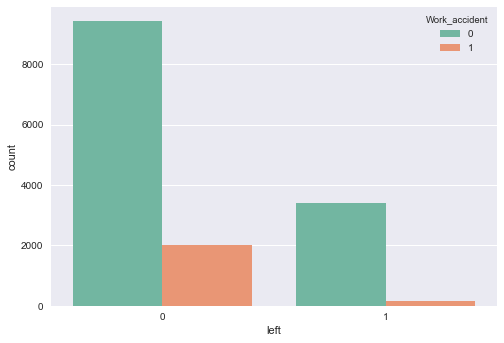

In [23]:
print(pd.crosstab(df.left,df.Work_accident, margins=True,normalize='columns'))
sns.countplot(x='left', hue='Work_accident', data=df, palette='Set2')

In [24]:
chi2_test(df.left,df.Work_accident,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: Work_accident            0            1
left                                   
0              9775.401027  1652.598973
1              3054.598973   516.401027


### Promotion last 5 years

promotion_last_5years         0         1       All
left                                               
0                      0.758038  0.940439  0.761917
1                      0.241962  0.059561  0.238083


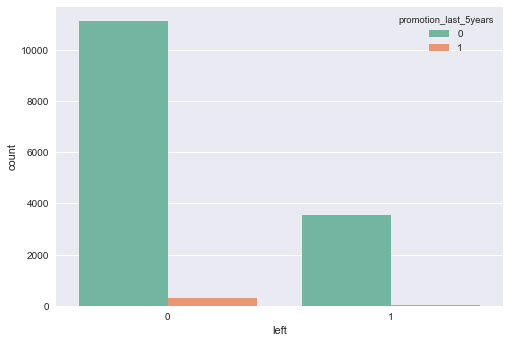

In [25]:
print(pd.crosstab(df.left,df.promotion_last_5years, margins=True,normalize='columns'))
sns.countplot(x='left', hue='promotion_last_5years', data=df, palette='Set2')

In [26]:
chi2_test(var1=df.left,var2=df.promotion_last_5years,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: promotion_last_5years            0          1
left                                         
0                      11184.94833  243.05167
1                       3495.05167   75.94833


### Transformación de variables

* Aplicamos dos transformaciones de variables a las dos variables categóricas que tenemos:

    * Como la variable salario es una variable categórica ordinal, es posible transformarla a número sin perder la 
    naturaleza de lo que representan las categorías bajo, medio, alto.
    
    * Como la variable sales es una variable categórica no ordinal, transformamos todas sus variables en variables 
    dummy, con el objetivo de identificar si es que existe alguna relación entre estar en algún departamento en 
    particular y que la probabilidad de fuga sea más alta o baja
    

* Es importante notar que la variable salario también la pudimos haber transformado en variable dummy para medir el efecto particular de tener un tipo de salario en particular. Sin embargo, el supuesto detrás de no hacerlo es que pensamos que mantener el ordenamiento de sus categorías aporta en la predicción de fuga

In [27]:
df.salary = df.salary.astype('category').cat.reorder_categories(['low', 'medium', 'high'])
salary_numeric = pd.DataFrame(df.salary.cat.codes)
salary_numeric.columns = ['salary']
df = df.drop(['salary'], 1).join(salary_numeric)

In [28]:
sales_dummies = pd.get_dummies(df.sales)
df = df.drop(['sales'], 1).join(sales_dummies)

### Aplicamos el test chi2 sobre las variables categóricas no ordinales

* Las variables categóricas en el dataset son:

    * Sales (no ordinal)
    * promotion_last_5years (binaria)
    * Work_accident (binaria)
    * salary (ordinal)
    
    
* Se aplica un test no paramétrico como el test chi2 para determinar si las categorías de la variable sales son independientes con respecto al target. Luego del cual confirmamos que solo las variables management,hr y RandD no presentan independencia y el resto de las categoría de sales si

*<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2>*


* En consecuencia, todas las categorías que son independientes con el target en este test son candidatas a ser eliminadas durante la selección de variables ya que no presentan significancia de forma individual. Dado que puede presentar significancia conjunta (en interacción con otras variables) confirmaremos su eliminación utilizando RFE con modelos de SVC lineal, Random Forest y Gradient Boosting

In [63]:
chi2(y=df.left,X=df[['management','hr','RandD','product_mng','IT','marketing','sales','accounting',
                     'support','technical']])

(array([  3.04516067e+01,   1.13793626e+01,   3.08564507e+01,
          1.71479003e+00,   1.64371371e+00,   1.04417630e-02,
          1.06932924e+00,   3.28865914e+00,   1.46206955e+00,
          4.94905082e+00]),
 array([  3.42299713e-08,   7.42645951e-04,   2.77837057e-08,
          1.90365066e-01,   1.99816694e-01,   9.18609877e-01,
          3.01097003e-01,   6.97599693e-02,   2.26601121e-01,
          2.61049970e-02]))

### Aplicamos el test chi2 sobre las variables dummy y categóricas ordinales

* Los resultados nos dicen que para las 3 variables evaluadas no es posible establecer independencia con el target, por lo cual son candidatas a ser seleccionadas

In [55]:
chi2(y=df.left,X=df[['promotion_last_5years','Work_accident','salary']])

(array([  56.04486528,  306.73771049,  255.27671404]),
 array([  7.08359651e-14,   1.12177164e-68,   1.83702643e-57]))

In [120]:
aux=df.copy()
X = df.drop(['left'], 1).copy()
y = df.left

### Estandarización de valores

* Utilizamos la función StandarScaler() de la librería SkLearn para aplicar el método de estandarización de valores para todas las variables numéricas que tenemos en el dataset (lo cual no incluye a los booleanos que están como 1 o 0) *<http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler>*


* Con un fin explicativo se muestra la variable de horas mensuales promedio trabajada en los últimos 12 meses con y sin escalamiento, en donde podemos ver que la transformación no genera cambios en la distribución de la variable sino que solo modifica los rangos de valores en los que se mueve estableciendo una desviación estandar unitaria (1) y centra la media en 0


* También notamos, que por la misma razón, no cambia la relación lineal entre las variables cuando aplicamos la correlación de pearson frente a otras variables numéricas y por lo tanto obtenemos exactamente los mismos valores para esta métrica


* Ocupamos la estandarización ya que no tenemos presencia importante de outliers en las 5 variables a las cuales aplicaremos la función (revisar boxplots individuales). En caso de que así fuera, se recomienda utilizar otros tipos de escalamiento, en particular el RobusScaler y QuantilScaler son los más usados en esos casos


* Para comprender las diferencias entre los distintos tipos de escalamiento utilizables con SkLearn se recomienda este link:  *<http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html>*

In [121]:
sc = StandardScaler()
aux=X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']]
sc.fit(aux)
X_std = sc.transform(aux)
X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']]=X_std

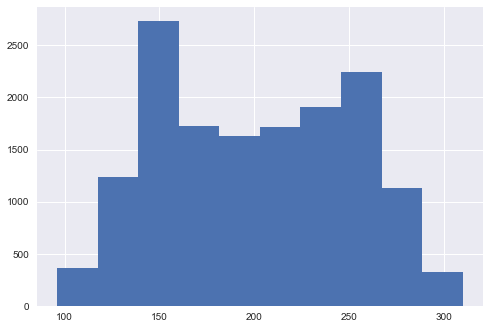

In [147]:
aux.average_montly_hours.hist()

count    1.499900e+04
mean    -4.978720e-16
std      1.000033e+00
min     -2.103471e+00
25%     -9.020633e-01
50%     -2.103137e-02
75%      8.800240e-01
max      2.181549e+00
Name: average_montly_hours, dtype: float64


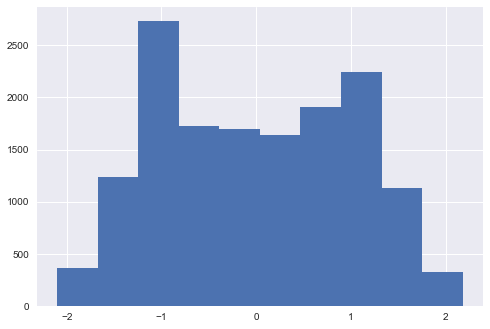

In [149]:
print(X.average_montly_hours.describe())
X.average_montly_hours.hist()

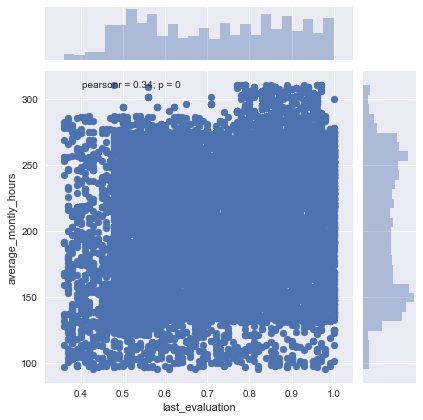

In [129]:
sns.jointplot(aux.last_evaluation,aux.average_montly_hours)

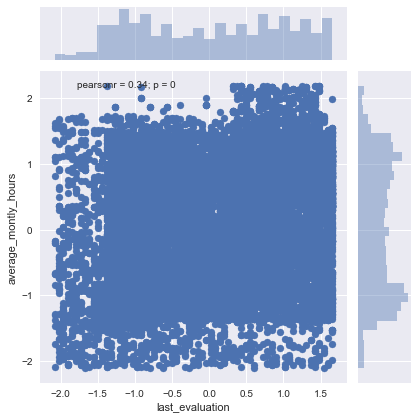

In [131]:
sns.jointplot(X.last_evaluation,X.average_montly_hours)

In [150]:
aux.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000


In [122]:
X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']].corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000


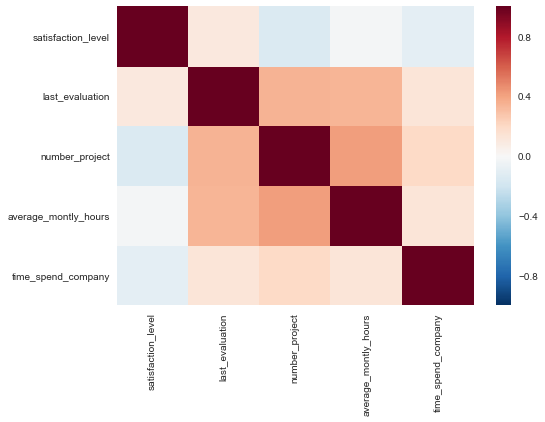

In [123]:
sns.heatmap(X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']].corr())

### Generamos un dataset balanceado con la técnica de Random Under sample

* Aplicamos la simple técnica de Random Under Sampling para balancear la clase minoritaria con la mayoritaria (fuga vs no fuga) Esta técnica consiste en generar una muestra aleatoria de los registros que tienen la clase mayoritaria como valor en el target con la misma cantidad de datos que la clase minoritaria

* El riesgo de esta técnica es que el muestreo aleatorio no sea suficiente para representar adecuadamente la composicion de los registros de la clase mayoritaria

* Para revisar un resumen muy explicativo de las técnicas para balancear clases se recomienda visitar el siguiente link: *<https://www.svds.com/learning-imbalanced-classes/>*

Información del dataset con Random Under Sampling:
 y: Counter({0: 3571, 1: 3571})


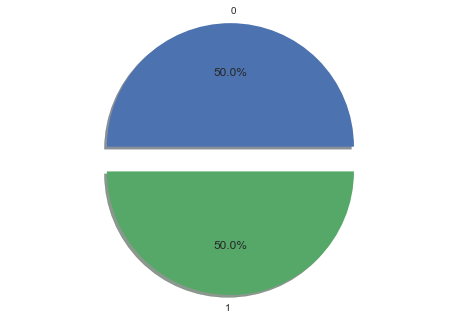

In [91]:
X_us, y_us , index_us= RandomUnderSampler(
    ratio='not minority', random_state=0,return_indices=True
).fit_sample(X, y)
print('Información del dataset con Random Under Sampling:'
      '\n y: {}'.format(Counter(y_train_us)))
plot_pie(y_train_us)

In [92]:
%%time
clf = RandomForestClassifier(
    bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=50,
    n_estimators=500,random_state=0,class_weight='balanced',n_jobs=-1, min_samples_leaf =50)
# Entreno el modelo
clf.fit(X, y)

CPU times: user 6.29 s, sys: 244 ms, total: 6.54 s
Wall time: 2.57 s


                 features  importance    weight
0      satisfaction_level    0.294384  1.000000
4      time_spend_company    0.264297  0.897794
2          number_project    0.161408  0.548289
3    average_montly_hours    0.135183  0.459206
1         last_evaluation    0.118715  0.403264
5           Work_accident    0.012158  0.041299
7                  salary    0.009371  0.031833
6   promotion_last_5years    0.000975  0.003313
17              technical    0.000918  0.003118
15                  sales    0.000673  0.002285
12             management    0.000553  0.001879
9                   RandD    0.000398  0.001353
16                support    0.000329  0.001119
11                     hr    0.000296  0.001005
8                      IT    0.000123  0.000418
10             accounting    0.000095  0.000322
14            product_mng    0.000079  0.000268
13              marketing    0.000045  0.000154


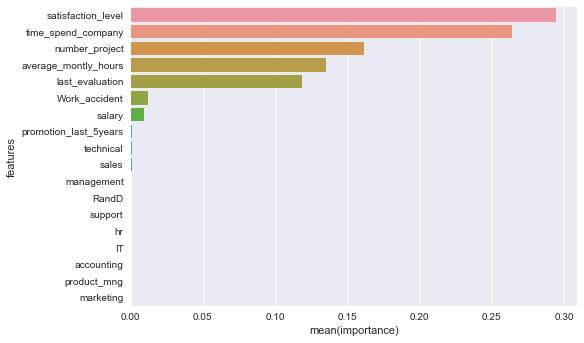

In [93]:
# Creamos el dataframe con los resultados
arr=clf.feature_importances_/np.max(clf.feature_importances_)
raw_data={'features':X.columns.values,'importance':clf.feature_importances_,'weight':arr}
features_rf=pd.DataFrame(raw_data,columns=['features','importance','weight'])
features_rf=features_rf[features_rf['importance']>0].sort_values(by='weight',ascending=False)
print(features_rf)
sns.barplot(x='importance', y='features', data=features_rf)

In [94]:
%%time
mi = mutual_info_classif(X,y,random_state=0,discrete_features='auto')

CPU times: user 2.61 s, sys: 26.6 ms, total: 2.63 s
Wall time: 2.65 s


                 features   m-score  m-weight
0      satisfaction_level  0.265709  1.000000
2          number_project  0.177603  0.668412
3    average_montly_hours  0.128516  0.483673
1         last_evaluation  0.099623  0.374932
4      time_spend_company  0.083505  0.314272
7                  salary  0.017890  0.067329
5           Work_accident  0.017456  0.065696
12             management  0.006570  0.024726
15                  sales  0.006001  0.022586
6   promotion_last_5years  0.004868  0.018323
8                      IT  0.004464  0.016801
17              technical  0.004315  0.016241
10             accounting  0.001218  0.004585


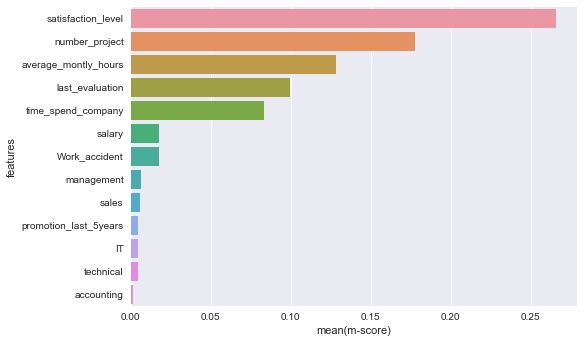

In [95]:
# Creamos el dataframe con los resultados
raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
features_mi=features_mi[features_mi['m-score']>0].sort_values(by='m-weight',ascending=False)
print(features_mi)
sns.barplot(x='m-score', y='features', data=features_mi)

In [96]:
features_uni=pd.merge(left=features_rf,right=features_mi, how='outer', on='features', left_on=None, right_on=None,
                           left_index=False, right_index=False, sort=False,suffixes=('_mi', '_rf'), copy=True, 
                           indicator=False)
features_uni.sort_values(by='m-score',ascending=False)

,features,importance,weight,m-score,m-weight
0,satisfaction_level,0.294384,1.000000,0.265709,1.000000
2,number_project,0.161408,0.548289,0.177603,0.668412
3,average_montly_hours,0.135183,0.459206,0.128516,0.483673
4,last_evaluation,0.118715,0.403264,0.099623,0.374932
1,time_spend_company,0.264297,0.897794,0.083505,0.314272
6,salary,0.009371,0.031833,0.017890,0.067329
5,Work_accident,0.012158,0.041299,0.017456,0.065696
10,management,0.000553,0.001879,0.006570,0.024726
9,sales,0.000673,0.002285,0.006001,0.022586
7,promotion_last_5years,0.000975,0.003313,0.004868,0.018323


## Selección de variables con RFE

* Ahora vamos a usar la técnica de RFE (recursive feature engineer) para seleccionar variables. Esta técnica va ejecutando de forma recursiva el modelo y elimina la variable menos relevante en cada iteración. Con esto se construye un ranking de importancia de variables que permite ordenarlas según su importancia.

* Para aplicar esta técnica es necesario que el modelo tenga como output una estimación de la importancia de variables que sirva para ordenar, en particular usaremos Random Forest, Gradient Boosting y Regresión logística

In [97]:
%%time
# Extracción de variables con RFE
model = LogisticRegression(random_state=0,warm_start=True)
rfe_lr = RFE(model, n_features_to_select=1)
fit_rl = rfe_lr.fit(X_train_us, y_train_us)

CPU times: user 241 ms, sys: 15.7 ms, total: 257 ms
Wall time: 264 ms


In [98]:
raw_data={'features':X.columns.values,'ranking':fit_rl.ranking_}
features_ffe_rl=pd.DataFrame(raw_data,columns=['features','ranking']).sort_values(by='ranking',ascending=True)
selected_features=pd.merge(left=features_uni,right=features_ffe_rl, how='right', on='features', left_on=None, right_on=None,
                           left_index=False, right_index=False, sort=False,suffixes=('_bf', '_ffe_rl'), copy=True, 
                           indicator=False)
selected_features.sort_values(by='ranking',ascending=True)

,features,importance,weight,m-score,m-weight,ranking
0,satisfaction_level,0.294384,1.000000,0.265709,1.000000,1
5,Work_accident,0.012158,0.041299,0.017456,0.065696,2
7,promotion_last_5years,0.000975,0.003313,0.004868,0.018323,3
6,salary,0.009371,0.031833,0.017890,0.067329,4
10,management,0.000553,0.001879,0.006570,0.024726,5
1,time_spend_company,0.264297,0.897794,0.083505,0.314272,6
11,RandD,0.000398,0.001353,NaN,NaN,7
4,last_evaluation,0.118715,0.403264,0.099623,0.374932,8
2,number_project,0.161408,0.548289,0.177603,0.668412,9
13,hr,0.000296,0.001005,NaN,NaN,10


In [99]:
%%time
model = RandomForestClassifier(
    bootstrap=True, class_weight='balanced', criterion='gini',max_features='sqrt',
    n_estimators=500,random_state=0,n_jobs=-1, min_samples_leaf = 50,min_samples_split=50)
rfe_rf = RFE(model, n_features_to_select=1)
fit_rf = rfe_rf.fit(X, y)
print("Num Features: %d" % fit_rf.n_features_)
print("Selected Features: %s" % fit_rf.support_)
print("Feature Ranking: %s" % fit_rf.ranking_)
X.loc[:,fit_rf.support_].columns.values

Num Features: 1
Selected Features: [ True False False False False False False False False False False False
 False False False False False False]
Feature Ranking: [ 1  5  4  3  2  6 10  7 15 12 16 14 11 18 17  9 13  8]
CPU times: user 1min 45s, sys: 3.35 s, total: 1min 48s
Wall time: 49 s


In [100]:
raw_data={'features':X.columns.values,'ranking':fit_rf.ranking_}
features_ffe_rf=pd.DataFrame(raw_data,columns=['features','ranking']).sort_values(by='ranking',ascending=True)
selected_features=pd.merge(left=features_ffe_rf,right=selected_features, how='right', on='features', 
                           left_on=None, right_on=None,left_index=False, right_index=False, 
                           sort=False,suffixes=('_rf', '_rl'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_rf',ascending=True)

,features,ranking_rf,importance,weight,m-score,m-weight,ranking_rl
0,satisfaction_level,1,0.294384,1.000000,0.265709,1.000000,1
1,time_spend_company,2,0.264297,0.897794,0.083505,0.314272,6
2,average_montly_hours,3,0.135183,0.459206,0.128516,0.483673,18
3,number_project,4,0.161408,0.548289,0.177603,0.668412,9
4,last_evaluation,5,0.118715,0.403264,0.099623,0.374932,8
5,Work_accident,6,0.012158,0.041299,0.017456,0.065696,2
6,salary,7,0.009371,0.031833,0.017890,0.067329,4
7,technical,8,0.000918,0.003118,0.004315,0.016241,12
8,sales,9,0.000673,0.002285,0.006001,0.022586,15
9,promotion_last_5years,10,0.000975,0.003313,0.004868,0.018323,3


In [101]:
%%time
# Extracción de variables con RFE
model = GradientBoostingClassifier(
    random_state=0,max_features='sqrt',subsample=0.8,
    learning_rate=0.01, max_depth=5,n_estimators=500,
    min_samples_split = 70,warm_start=True,presort=True)
rfe_gb = RFE(model, n_features_to_select=1)
fit_gb = rfe_gb.fit(X=X_train_us, y=y_train_us)

CPU times: user 36.5 s, sys: 79 ms, total: 36.5 s
Wall time: 36.7 s


In [102]:
raw_data={'features':X.columns.values,'ranking_gb':fit_gb.ranking_}
features_ffe_gb=pd.DataFrame(raw_data,columns=['features','ranking_gb']).sort_values(by='ranking_gb',ascending=True)
selected_features=pd.merge(left=features_ffe_gb,right=selected_features, how='right', on='features', 
                           left_on=None, right_on=None,left_index=False, right_index=False, 
                           sort=False,suffixes=('_gb', '_sf'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_gb',ascending=True)

,features,ranking_gb,ranking_rf,importance,weight,m-score,m-weight,ranking_rl
0,satisfaction_level,1,1,0.294384,1.000000,0.265709,1.000000,1
1,time_spend_company,2,2,0.264297,0.897794,0.083505,0.314272,6
2,average_montly_hours,3,3,0.135183,0.459206,0.128516,0.483673,18
3,number_project,4,4,0.161408,0.548289,0.177603,0.668412,9
4,last_evaluation,5,5,0.118715,0.403264,0.099623,0.374932,8
5,salary,6,7,0.009371,0.031833,0.017890,0.067329,4
6,Work_accident,7,6,0.012158,0.041299,0.017456,0.065696,2
7,product_mng,8,17,0.000079,0.000268,NaN,NaN,16
8,technical,9,8,0.000918,0.003118,0.004315,0.016241,12
9,hr,10,14,0.000296,0.001005,NaN,NaN,10


### Usando linear suport vector classification

* Se utiliza el algoritmo linear suport vector classification con penalización l1 para estimar los coeficientes y un coeficiente de 0.005, los cuales son llevados a valor absoluto para luego ser rankeados en orden de importancia

*<http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html>*

*<https://datascience.stackexchange.com/questions/6987/can-you-explain-the-difference-between-svc-and-linearsvc-in-scikit-learn>*

*<https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/>*

In [103]:
%%time
lsvc = LinearSVC(C=0.005, penalty="l1", random_state=0,dual=False,
                 loss='squared_hinge').fit(X_train_us, y_train_us)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(14999, 6)
CPU times: user 77.6 ms, sys: 2.58 ms, total: 80.1 ms
Wall time: 80.7 ms


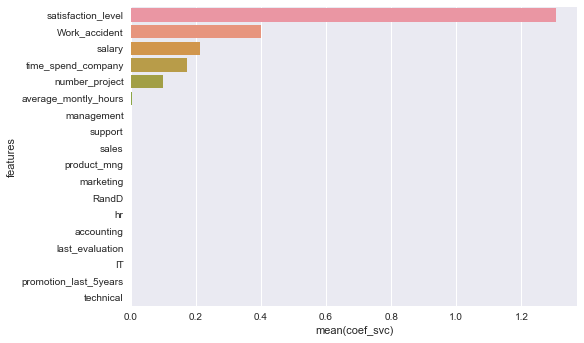

In [104]:
raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
sns.barplot(x='coef_svc', y='features', data=features_svc)

In [105]:
selected_features=pd.merge(left=features_svc,right=selected_features, how='right', on='features', 
                           left_on=None, right_on=None,left_index=False, right_index=False, 
                           sort=False,suffixes=('_svc', '_sf'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_gb',ascending=True)

,features,coef_svc,ranking_svc,ranking_gb,ranking_rf,importance,weight,m-score,m-weight,ranking_rl
0,satisfaction_level,1.305496,1,1,1,0.294384,1.000000,0.265709,1.000000,1
3,time_spend_company,0.172489,4,2,2,0.264297,0.897794,0.083505,0.314272,6
5,average_montly_hours,0.002483,6,3,3,0.135183,0.459206,0.128516,0.483673,18
4,number_project,0.100469,5,4,4,0.161408,0.548289,0.177603,0.668412,9
14,last_evaluation,0.000000,15,5,5,0.118715,0.403264,0.099623,0.374932,8
2,salary,0.213063,3,6,7,0.009371,0.031833,0.017890,0.067329,4
1,Work_accident,0.399984,2,7,6,0.012158,0.041299,0.017456,0.065696,2
9,product_mng,0.000000,10,8,17,0.000079,0.000268,NaN,NaN,16
17,technical,0.000000,18,9,8,0.000918,0.003118,0.004315,0.016241,12
12,hr,0.000000,13,10,14,0.000296,0.001005,NaN,NaN,10


## Principales conclusiones

* Utilizando los resultados presentados en la última tabla, seleccionamos las siguientes variables:

     * nivel de satisfacción
     * tiempo en la compañia
     * número de horas trabajas promedio mensualmente en los últimos 12 meses
     * Número de proyectos en los que ha participado
     + última evaluación
     * Salario
    
    
* Argumentos para descartar la variable última evaluación porque: 
    
    * Aparece consistentemente como una variable significativa cuando utilizamos los algoritmos de árboles (RF y
    GB), pero al momento de utilizar el algoritmo de RL y SVC lineal el peso de esta variable es significativamente
    menor. 
    
    * Si observamos su distribución según valor del target, podemos ver que es bastante similar y, en promedio, no
    presenta diferencias (0.71 ambos) y sus desviaciones son muy similares (0.16 vs 0.19). 
    

* Argumentos para no descartar la variable última evaluación:
    
    * Es posible que su significancia sea conjunta y no individual, y por esa razón los árboles capturan bien su 
    importancia mientras que el RFE con Regresión logística no
    
    * Siguiendo la linea del argumento anterior, Tiene una correlación media con las variables número de 
    proyectos y número de horas promedio trabajadas en los últimos 12 meses (0.35 y 0.34), por lo tanto es 
    posible que el modelo de regresión lineal logístico se vea afectado por esto y que lo más conveniente hubiera 
    sido crear una variable que demuestre la interacción entre estas 3 variables
    
    * Es posible que su relación con el target no sea lineal y por lo tanto los modelos lineales no capturan 
    adecuadamente su importancia en términos de detección de patrones que permiten predecir la fuga
    
    * Por la misma razón de arriba que SVC lineal no haya detectado relevancia en la variable última evaluació     
    porque no puede encontrar el vector de separación de forma lineal y habría que usar una variación de este
    
    * Fuentes utilizadas:
    
    *<http://www.estadistica.net/ECONOMETRIA/CUALITATIVAS/LOGISTICA/regresion-logistica.pdf>*
    
    *<https://github.com/rasbt/python-machine-learning-book/blob/master/faq/select_svm_kernels.md>*


* Posteriormente, utilizamos un criterio de negocio para descartar la variable de accidente en el trabajo, a pesar de que obtiene un buen ranking en todas las evaluaciones. Nuestra hipótesis es que se trata de un falso predictor .Si observamos cómo se distribuye esta según valor del target, podemos ver que hay que la proporción de accidentes es mayor en las personas que se quedan que en las que se van.Esto se puede presentar por varias razones, pero es poco razonable pensar que una de las razones para no irse es no tener accidentes en el trabajo o bien que una de las razones para quedarse es tener más accidentes en el trabajo.


* El resto de las variables está consistentemente evaluada por debajo de las primeras 10 en todos los algoritmos, con puntajes bajos (y peso relativo bajo) y/o una mezcla de ambos